* Master DAC, BDLE, 2021 
* Author:Kamel NAIT SLIMANI
* Affiliation: Faculté des Sciences - Sorbonne Université
* Email: kamel.nait_slimani@etu.sorbonne-universite.fr


#Spark Session Préparation

Vérifier que des ressources de calcul sont allouées à votre notebook est connecté (cf RAM  de disque indiqués en haut à droite) . Sinon cliquer sur le bouton connecter pour obtenir des ressources.




Pour accéder directement aux fichiers stockées sur votre google drive. Renseigner le code d'authentification lorsqu'il est demandé

In [1]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/dir/DM2"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)


Mounted at /content/drive


['census-income.data.gz',
 'census-income.data',
 'census-income.test.gz',
 'census-income.test',
 'train_data.parquet',
 'test_data.parquet']

Installer pyspark et findspark :


In [2]:
!pip install -q pyspark
!pip install -q findspark

Démarrer la session spark

In [3]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [4]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "15G").\
  set("spark.driver.memory","25G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1636599436622


In [5]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


In [6]:
import pandas as pd
from google.colab import data_table
# Alternative to Databricks display function.
pd.options.display.max_colwidth = 400

def display(df, n=10000):
  return data_table.DataTable(df.limit(n).toPandas(), include_index=False, num_rows_per_page=10)


#Data Downloading


In [7]:
import os
from urllib import request
import gzip

url_train =  "http://kdd.ics.uci.edu/databases/census-income/census-income.data.gz"
url_test =  "http://kdd.ics.uci.edu/databases/census-income/census-income.test.gz"
# temp = "/temp"
local_archive_train = drive_dir +"/census-income.data.gz"
local_archive_test = drive_dir +"/census-income.test.gz"
local_train=drive_dir +"/census-income.data"
local_test= drive_dir +"/census-income.test"
os.makedirs(drive_dir,exist_ok=True)


if(os.path.isfile(local_train)):
  print("train data already downloaded")
else:
  print("downloading from URL: ", url_train, "save in : ", local_archive_train)
  request.urlretrieve(url_train, local_archive_train)
  os.chdir(drive_dir)
  print(drive_dir,local_archive_train)
  with  gzip.open(local_archive_train,"rb") as gz_f:
    with open(local_train,"wb") as f:
      f.write(gz_f.read())


if(os.path.isfile(local_archive_test)):
  print("test data already downloaded")
else:
  print("downloading from URL: ", url_test, "save in : ", local_archive_test)
  request.urlretrieve(url_test, local_archive_test)
  os.chdir(drive_dir)
  with  gzip.open(local_archive_test,"rb") as gz_f:
    with open(local_test,"wb") as f:
      f.write(gz_f.read())

#liste des fichier des données 
os.listdir(drive_dir)

train data already downloaded
test data already downloaded


['census-income.data.gz',
 'census-income.data',
 'census-income.test.gz',
 'census-income.test',
 'best_clf.pkl']

#Data Processing

##Data Loading and cleanning
Dans cette section nous avons chercher une base de donées et nous avons crée le dataFrame suivant le schema des données puis enlever des features avec une trés grande varience et ceux qui sont présque pareil pour toutes les instances

In [14]:
schema="""AAGE float , 
ACLSWKR string , 
ADTIND string , 
ADTOCC string , 
AHGA string , 
AHRSPAY float , 
AHSCOL string , 
AMARITL string , 
AMJIND string , 
AMJOCC string , 
ARACE string , 
AREORGN string , 
ASEX string , 
AUNMEM string , 
AUNTYPE string , 
AWKSTAT string , 
CAPGAIN float , 
CAPLOSS float , 
DIVVAL float , 
FILESTAT string , 
GRINREG string , 
GRINST string , 
HHDFMX string , 
HHDREL string , 
MARSUPWT float,
MIGMTR1 string , 
MIGMTR3 string , 
MIGMTR4 string , 
MIGSAME string , 
MIGSUN string , 
NOEMP float , 
PARENT string , 
PEFNTVTY string , 
PEMNTVTY string , 
PENATVTY string , 
PRCITSHP string , 
SEOTR string , 
VETQVA string , 
VETYN string , 
WKSWORK float , 
YEAR string ,
Label string"""


In [39]:
train_dataset = spark.read.csv(path = drive_dir + "/census-income.data",schema=schema).persist()
test_dataset=spark.read.csv(path = drive_dir + "/census-income.test",schema=schema).persist()

In [16]:
distinct_values=train_dataset.agg(*(countDistinct(col(c)).alias(c) for c in test_dataset.columns))

In [17]:
distinct_values.show()

+----+-------+------+------+----+-------+------+-------+------+------+-----+-------+----+------+-------+-------+-------+-------+------+--------+-------+------+------+------+--------+-------+-------+-------+-------+------+-----+------+--------+--------+--------+--------+-----+------+-----+-------+----+-----+
|AAGE|ACLSWKR|ADTIND|ADTOCC|AHGA|AHRSPAY|AHSCOL|AMARITL|AMJIND|AMJOCC|ARACE|AREORGN|ASEX|AUNMEM|AUNTYPE|AWKSTAT|CAPGAIN|CAPLOSS|DIVVAL|FILESTAT|GRINREG|GRINST|HHDFMX|HHDREL|MARSUPWT|MIGMTR1|MIGMTR3|MIGMTR4|MIGSAME|MIGSUN|NOEMP|PARENT|PEFNTVTY|PEMNTVTY|PENATVTY|PRCITSHP|SEOTR|VETQVA|VETYN|WKSWORK|YEAR|Label|
+----+-------+------+------+----+-------+------+-------+------+------+-----+-------+----+------+-------+-------+-------+-------+------+--------+-------+------+------+------+--------+-------+-------+-------+-------+------+-----+------+--------+--------+--------+--------+-----+------+-----+-------+----+-----+
|  91|      9|    52|    47|  17|   1240|     3|      7|    24|    15|   

<Figure size 8640x8640 with 0 Axes>

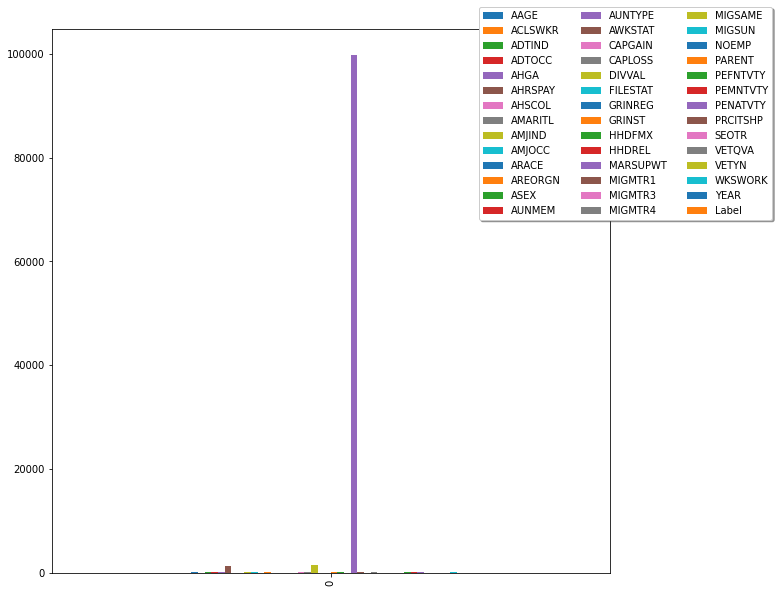

In [18]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(120,120))

histogram = distinct_values.rdd.histogram(1)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
print()
pd.DataFrame(
    [list(histogram[0][0])],columns=distinct_values.columns
).plot(kind='bar',figsize=(10,10))
plt.legend( bbox_to_anchor=(1.3, 1.05),
          ncol=3, fancybox=True, shadow=True)

In [40]:
cols_to_remove=["YEAR","MIGSAME"]

In [41]:
test_dataset=test_dataset.drop(*cols_to_remove)
train_dataset=train_dataset.drop(*cols_to_remove)
test_dataset=test_dataset.dropDuplicates()
train_dataset=train_dataset.dropDuplicates()

##Data Transformation
Dans cette section nous avons éffectué des transformation:


In [19]:
from pyspark.ml.feature import MinMaxScaler,VectorIndexer , VectorAssembler,StringIndexer 
from pyspark.ml import Pipeline
import gc
gc.collect()

480

In [22]:
def normalizer(col):
  assembler=VectorAssembler(inputCols=[col],outputCol="vect_"+col)
  scaler=MinMaxScaler(inputCol="vect_"+col,outputCol="scal_"+col)
  return Pipeline(stages=[assembler, scaler])

In [23]:
string_columns=[ c.split(" ")[0]  for c in  schema.split('\n') if c.split(" ")[1]=="string" and c.split(" ")[0] not in cols_to_remove ]
continous_columns=[ c.split(" ")[0]  for c in  schema.split('\n') if c.split(" ")[1]=="float" and c.split(" ")[0] not in cols_to_remove ]
label = 'Label'
features_col= string_columns
features_col.remove(label)
index_prefix = 'indexed_'

label_string_indexer= StringIndexer(inputCol=label, outputCol=index_prefix+label)

features_str_col= list(map(lambda c:index_prefix+c, features_col))

features_string_indexer= StringIndexer(inputCols=features_col,outputCols=features_str_col)

#Columns values normalizers to have values between 0-1
features_normalizers = [ normalizer(c) for c in (features_string_indexer.getOutputCols()+continous_columns) ]

Scal_cols=[ "scal_"+c for c in (features_string_indexer.getOutputCols()+continous_columns)]

vec_assembler= VectorAssembler(inputCols=Scal_cols,outputCol= 'vector')
vec_indexer= VectorIndexer(inputCol='vector',outputCol='features', maxCategories=15)



In [24]:
from pyspark.ml import Pipeline
stages = [label_string_indexer,features_string_indexer]
stages.extend(features_normalizers)
stages.extend([vec_assembler,vec_indexer])
pipeline = Pipeline(stages = stages)

In [42]:
train_data= pipeline.fit(train_dataset).transform(train_dataset)

In [45]:
test_data= pipeline.fit(test_dataset).transform(test_dataset)

In [77]:
train_dataset,test_dataset=None,None
gc.collect()
spark.sparkContext._jvm.System.gc()

##Data Statistics and dashboards

In [ ]:
description=train_data.select(features_string_indexer.getOutputCols()+continous_columns).describe()

In [ ]:
description.toPandas()

,summary,indexed_ACLSWKR,indexed_ADTIND,indexed_ADTOCC,indexed_AHGA,indexed_AHSCOL,indexed_AMARITL,indexed_AMJIND,indexed_AMJOCC,indexed_ARACE,indexed_AREORGN,indexed_ASEX,indexed_AUNMEM,indexed_AUNTYPE,indexed_AWKSTAT,indexed_FILESTAT,indexed_GRINREG,indexed_GRINST,indexed_HHDFMX,indexed_HHDREL,indexed_MIGMTR1,indexed_MIGMTR3,indexed_MIGMTR4,indexed_MIGSUN,indexed_PARENT,indexed_PEFNTVTY,indexed_PEMNTVTY,indexed_PENATVTY,indexed_PRCITSHP,indexed_SEOTR,indexed_VETQVA,indexed_VETYN,AAGE,AHRSPAY,CAPGAIN,CAPLOSS,DIVVAL,NOEMP,WKSWORK
0,count,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432,25432
1,mean,1.1380150990877635,8.30795847750865,8.749252909720038,3.2892418999685438,0.05166719094054734,0.6620399496697075,4.947389116074238,2.5783658383139354,0.2129207297892419,0.29360648002516515,0.3850660585089651,0.1593661528782636,0.05221767851525637,0.6859861591695502,0.9639823843976093,0.154451085246933,0.9616231519345706,1.6117096571248821,0.8661528782636049,0.6114737338785782,0.6309374016986474,0.640059767222397,0.5747483485372759,0.19939446366782007,1.5736080528468073,1.5487967914438503,0.9652799622522806,0.17914438502673796,0.1520918527838943,0.016160742371815036,0.14969329977980497,40.2864108210129,68.73273828247876,2424.4072428436616,108.66974677571564,824.9200613400441,2.8988282478766907,34.6493787354514
2,stddev,1.577978081125802,10.555314023322502,10.89407640436182,3.5117353078153917,0.2851707816454263,1.022614670306638,5.335666121973219,2.9476566684425745,0.6421926482262595,1.0762418796197488,0.48662048885944237,0.4259987458628453,0.38454752745306564,1.0112863439635495,1.2498280777387818,0.65998726598968,4.964814835139912,2.641598727813081,1.2735051159964321,0.8646785899490358,0.9287456368026131,0.9864623176277336,0.6844556582911927,0.5557960343802585,5.104508080288965,5.033173906496141,4.134407426614481,0.5881739316387553,0.4342548517794222,0.13885927222480973,0.39526102399864466,19.055339527674455,359.17787356068305,12081.657377078773,463.293810935986,4999.058394592555,2.4706900076989853,23.322568824923472
3,min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,max,8.0,50.0,46.0,16.0,2.0,6.0,23.0,14.0,4.0,9.0,1.0,2.0,5.0,7.0,5.0,5.0,50.0,29.0,7.0,9.0,8.0,9.0,3.0,4.0,42.0,42.0,41.0,4.0,2.0,2.0,2.0,90.0,9999.0,99999.0,4356.0,99999.0,6.0,52.0


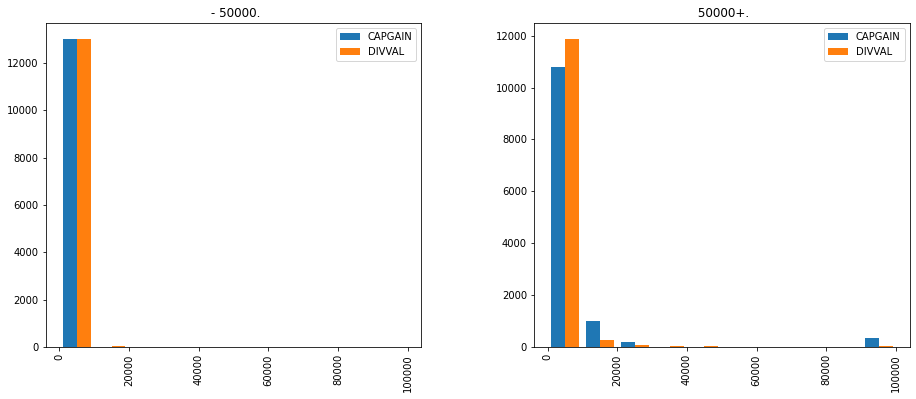

In [ ]:
train_data.select("Label","CAPGAIN","DIVVAL").toPandas().hist(figsize=(15,6),by="Label",column=["CAPGAIN","DIVVAL"],legend=True)
plt.legend()

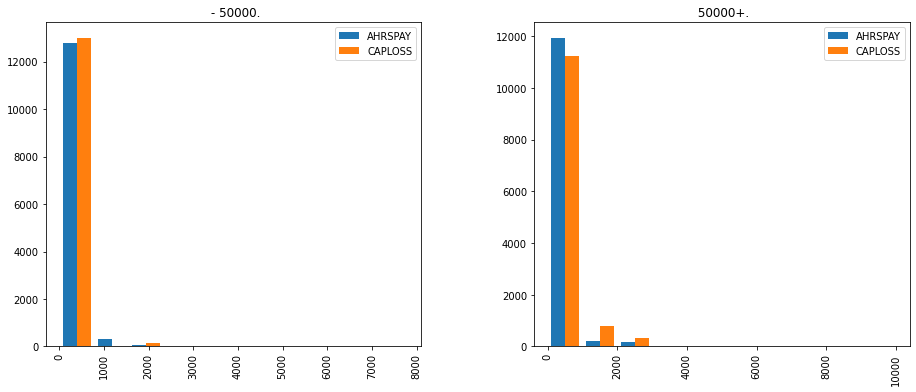

In [ ]:
train_data.select("Label","AHRSPAY","CAPLOSS").toPandas().hist(figsize=(15,6),by="Label",column=["AHRSPAY","CAPLOSS"],legend=True)
plt.legend()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4c9bd8f10>,
      dtype=object)

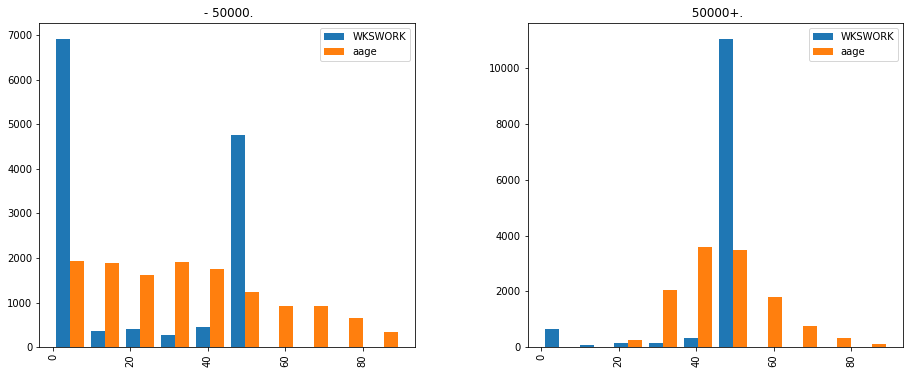

In [ ]:
train_data.select("Label","WKSWORK","aage").toPandas().hist(figsize=(15,6),by="Label",column=["WKSWORK","aage"],legend=True)

In [52]:
train_data.select("Label","ACLSWKR").groupBy("ACLSWKR","Label").count().orderBy("Label",col("count")).toPandas().transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
ACLSWKR,Without pay,Never worked,Self-employed-incorporated,Federal government,State government,Local government,Self-employed-not incorporated,Private,Not in universe,Without pay,Never worked,State government,Federal government,Local government,Not in universe,Self-employed-not incorporated,Self-employed-incorporated,Private
Label,- 50000.,- 50000.,- 50000.,- 50000.,- 50000.,- 50000.,- 50000.,- 50000.,- 50000.,50000+.,50000+.,50000+.,50000+.,50000+.,50000+.,50000+.,50000+.,50000+.
count,164,436,2130,2328,3742,6936,7352,64699,96125,1,2,485,597,847,904,1090,1134,7322


In [ ]:
train_data.select("Label","ASEX").groupBy("ASEX","Label").count().toPandas() 	

,ASEX,Label,count
0,Female,50000+.,2663
1,Male,50000+.,9719
2,Female,- 50000.,7133
3,Male,- 50000.,6059


####Normalizted Features


In [ ]:
train_data.select(Scal_cols).show()

+--------------------+--------------------+--------------------+-----------------+-------------------+--------------------+--------------------+--------------------+------------------+--------------------+-----------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+---------------------+---------------------+---------------------+---------------------+------------------+-------------------+------------------+--------------------+--------------------+------------+------------+-----------+--------------------+--------------------+
|scal_indexed_ACLSWKR| scal_indexed_ADTIND| scal_indexed_ADTOCC|scal_indexed_AHGA|scal_indexed_AHSCOL|scal_indexed_AMARITL| scal_indexed_AMJIND| scal_indexed_AMJOCC|scal_indexed_ARACE|scal_indexed_AREORGN|scal_indexed_ASEX|scal_indexed_

##Data features label Selection

In [49]:
train_data=train_data.select('features','indexed_Label')

In [50]:
test_data=test_data.select('features','indexed_Label')

In [51]:
gc.collect()
spark.sparkContext._jvm.System.gc()

##Transformed_data saving
Nous sauvegardons les features et les labels de train et de test si on a un probléme pour ne pas exécuter tout le pipeline à chaque fois que la session plante. 

In [72]:
train_data.write.save(drive_dir+"/train_data.parquet")

In [73]:
test_data.write.save(drive_dir+"/test_data.parquet",)

##Transformed Data Loading

In [81]:
train_data= spark.read.load(drive_dir+"/train_data.parquet")
test_data=spark.read.load(drive_dir+"/test_data.parquet")

##Data Balancing
Pour êtres dans la limite des données demandée nous avons fait un undersampling sur la classes majoritaire dans les données de train et de test

In [82]:
train_Positive_class = train_data.filter(col("indexed_Label") == 1 )
train_Negative_class =train_data.filter(col("indexed_Label") == 0 )
test_Positive_class=test_data.filter(col("indexed_Label") == 1 )
test_Negative_class=test_data.filter(col("indexed_Label") ==  0 )

In [83]:
minor_class_train=int(train_Positive_class.count())
train_ratio = int(train_Negative_class.count()/minor_class_train)
test_ratio=int(test_Negative_class.count()/test_Positive_class.count())
print("train ratio: {}, test ratio: {}".format(train_ratio,test_ratio))

train ratio: 14, test ratio: 14


In [94]:
train_data_balanced_by_under_Sampling=train_Positive_class.unionAll(train_Negative_class.sample(False, 1/train_ratio))
fact=3
df=train_Positive_class.sample(0.99999999)
for x in range(int(train_ratio/8)):
  df=df.unionAll(train_Positive_class.sample(0.999999))
train_data_balanced_by_over_Sampling=df.unionAll(train_Negative_class.sample(False, 1/2))

In [77]:
#Pour qu'il garde pas les données en Ram
train_Positive_class,train_Negative_class,test_Positive_class,test_Negative_class=None,None,None,None
gc.collect()
spark.sparkContext._jvm.System.gc()

In [51]:
train_data_balanced_by_under_Sampling.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,1.0,12382
1,0.0,13216


In [95]:
train_data_balanced_by_over_Sampling.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,1.0,24764
1,0.0,91676


In [30]:
train_data.groupBy("indexed_Label").count().toPandas()

,indexed_Label,count
0,0.0,183912
1,1.0,12382


#Training And Testing Models

In [21]:
from pyspark.ml.classification import RandomForestClassifier ,LinearSVC,GBTClassifier
from  pyspark.ml.evaluation import BinaryClassificationEvaluator,MulticlassClassificationEvaluator

In [22]:
def predict_(model,data_test,col_features="features"):
  return model.transform(
      data_test.select(col_features,"indexed_Label").withColumnRenamed("indexed_Label","label")
      ).select("label","prediction")


In [23]:
def eval_Model(predictions):
  #Preppate test data
  mytrics=["accuracy","weightedPrecision","weightedRecall","fMeasureByLabel"]
  evaluator = MulticlassClassificationEvaluator(metricName='fMeasureByLabel', metricLabel=1, beta=1.0) 
  evalulations={}
  for mytric in mytrics:
    evaluator.setMetricName(mytric)
    evalulations[mytric]=evaluator.evaluate(predictions)
  return evalulations

##Train and Test with unbalanced data



###Random Forest Perforamances


In [118]:
eval_Model(predict_(RandomForestClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data),test_data))

{'accuracy': 0.9387837660170512,
 'fMeasureByLabel': 0.04421285330806884,
 'weightedPrecision': 0.9396154458012305,
 'weightedRecall': 0.9387837660170512}

###SVM Model Performances

In [115]:
eval_Model(predict_(LinearSVC(featuresCol="features",labelCol="indexed_Label").fit(train_data),test_data))

{'accuracy': 0.943213422465842,
 'fMeasureByLabel': 0.18658554251774592,
 'weightedPrecision': 0.9407048131562592,
 'weightedRecall': 0.9432134224658422}

###Gradient Boost Model Performances

In [122]:
eval_Model(predict_(GBTClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data),test_data))

{'accuracy': 0.9488364566793758,
 'fMeasureByLabel': 0.43632311977715876,
 'weightedPrecision': 0.9401117730762191,
 'weightedRecall': 0.9488364566793758}

##Train and Test with balanced data


In [ ]:
gc.collect()
spark.sparkContext._jvm.System.gc()

###By Under Sampling



####Random Forest Perforamances


In [119]:
eval_Model(predict_(RandomForestClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_under_Sampling),test_data))

{'accuracy': 0.7990877739459339,
 'fMeasureByLabel': 0.357420106093932,
 'weightedPrecision': 0.9430589080820581,
 'weightedRecall': 0.7990877739459339}

####SVM Model Performances

In [120]:
eval_Model(predict_(LinearSVC(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_under_Sampling),test_data))

{'accuracy': 0.943213422465842,
 'fMeasureByLabel': 0.18658554251774592,
 'weightedPrecision': 0.9407048131562592,
 'weightedRecall': 0.9432134224658422}

####Gradient Boost Model Performances

In [123]:
eval_Model(predict_(GBTClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_under_Sampling),test_data))

{'accuracy': 0.8453564457569352,
 'fMeasureByLabel': 0.4183498801780212,
 'weightedPrecision': 0.9463764506494498,
 'weightedRecall': 0.8453564457569351}

###By Over Sampling



####Random Forest Perforamances


In [97]:
eval_Model(predict_(RandomForestClassifier(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_over_Sampling),test_data))

{'accuracy': 0.9432437625785051,
 'fMeasureByLabel': 0.5295103957075789,
 'weightedPrecision': 0.9413690193176931,
 'weightedRecall': 0.943243762578505}

####SVM Model Performances

In [98]:
eval_Model(predict_(LinearSVC(featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_over_Sampling),test_data))

{'accuracy': 0.9321089412312018,
 'fMeasureByLabel': 0.498842851810377,
 'weightedPrecision': 0.9373390019374337,
 'weightedRecall': 0.9321089412312018}

####Gradient Boost Model Performances

In [99]:
eval_Model(predict_(GBTClassifier(maxBins=25,maxDepth=8,featuresCol="features",labelCol="indexed_Label").fit(train_data_balanced_by_over_Sampling),test_data))

{'accuracy': 0.9335652666390235,
 'fMeasureByLabel': 0.5613941376777726,
 'weightedPrecision': 0.9467322134903953,
 'weightedRecall': 0.9335652666390234}

##Train and test With features selection on overSampling balanced data

In [100]:
gc.collect()
spark.sparkContext._jvm.System.gc()

###Features selection with Threshold Variance
Aprés les expériences nous avons remarqué que avoir les toutes les propriétées dans les données nous aide a mieux faire la classification.

In [101]:
from pyspark.ml.feature import VarianceThresholdSelector

selector = VarianceThresholdSelector(varianceThreshold=0.5, outputCol="selectedFeatures").fit(train_data_balanced_by_over_Sampling)



In [102]:
cleaned_data_train = selector.transform(train_data_balanced_by_over_Sampling).\
select("selectedFeatures","indexed_label").\
withColumnRenamed("selectedFeatures","features")

print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())
cleaned_data_train.select("features","indexed_label").show(5)

Output: Features with variance lower than 0.500000 are removed.
+--------------------+-------------+
|            features|indexed_label|
+--------------------+-------------+
|(12,[0,2,5,7,8,9,...|          1.0|
|(12,[0,1,2,5,8,9,...|          1.0|
|(12,[0,2,5,8,9,10...|          1.0|
|(12,[0,2,5,8,9,10...|          1.0|
|(12,[0,2,4,5,7,11...|          1.0|
+--------------------+-------------+
only showing top 5 rows



In [103]:
cleaned_data_test = selector.transform(test_data).\
select("selectedFeatures","indexed_label").\
withColumnRenamed("selectedFeatures","features")

print("Output: Features with variance lower than %f are removed." %
      selector.getVarianceThreshold())
cleaned_data_test.select("features","indexed_label").show(5)

Output: Features with variance lower than 0.500000 are removed.
+--------------------+-------------+
|            features|indexed_label|
+--------------------+-------------+
|(12,[0,1,2,4,5,7,...|          0.0|
|(12,[0,2,5,7,8,9,...|          0.0|
|      (12,[7],[4.0])|          0.0|
|(12,[1,5,8,9,10],...|          0.0|
|(12,[0,1,2,3,4,5,...|          0.0|
+--------------------+-------------+
only showing top 5 rows



###Random Froest Performances

In [104]:
eval_Model(predict_(RandomForestClassifier(labelCol="indexed_label").fit(cleaned_data_train),cleaned_data_test))

{'accuracy': 0.9262532994872521,
 'fMeasureByLabel': 0.27123725764541273,
 'weightedPrecision': 0.912040780188376,
 'weightedRecall': 0.9262532994872521}

###Svm Performances

In [105]:
eval_Model(predict_(LinearSVC(labelCol="indexed_label").fit(cleaned_data_train),cleaned_data_test))

{'accuracy': 0.9316740662830328,
 'fMeasureByLabel': 0.07375925418151905,
 'weightedPrecision': 0.8958944877933679,
 'weightedRecall': 0.9316740662830327}

###Gradient Boost Model Performances

In [106]:
eval_Model(predict_(GBTClassifier(labelCol="indexed_label").fit(cleaned_data_train),cleaned_data_test))

{'accuracy': 0.9086560341427401,
 'fMeasureByLabel': 0.4180412371134021,
 'weightedPrecision': 0.9283821214359986,
 'weightedRecall': 0.9086560341427402}

##Grid Search Cross Validation on SGT boost with over simpled data 

In [107]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
def gridSearch_random_forest():
  gbt=GBTClassifier()
  paramGrid = ParamGridBuilder().addGrid(gbt.maxBins,[25,27])\
  .addGrid(gbt.maxDepth,[6,7])\
  .build()
  crossval = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3,parallelism=8)

  return crossval

In [108]:
data=train_data_balanced_by_over_Sampling.withColumnRenamed("indexed_Label","label")

In [109]:
gc.collect()
spark.sparkContext._jvm.System.gc()

In [110]:
best_model=gridSearch_random_forest().fit(data)

In [111]:
eval_Model(predict_(best_model,test_data))

{'accuracy': 0.9327460835971237,
 'fMeasureByLabel': 0.5639344262295083,
 'weightedPrecision': 0.9474330271569962,
 'weightedRecall': 0.9327460835971237}